# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [4]:
USER_NAME = u"Хорошенький".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [55]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C = 1, alpha = 0.01, max_epoch = 10, random_state=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.random_state = random_state
    
    def fit(self, X, y=None):
        np.random.seed(self.random_state)

        # столбец с единицами - для свободного члена (в начало Х)
        X = np.c_[np.ones(X.shape[0]), X]
        y[y == 0] = -1
        
        self.beta = np.zeros(X.shape[1], dtype=np.float64)
        new_beta  = np.zeros(X.shape[1], dtype=np.float64)
        self.errors = []
        
        df_X = pd.DataFrame(X)
        for epoch in xrange(1, self.max_epoch + 1):
            mesh = np.random.permutation(X.shape[0])
            X = X[mesh]
            y = y[mesh]

            for step in xrange(X.shape[0]):
                if step <  X.shape[0] - 5:
                    X_items = X[step: step + 5]
                    y_items = y[step: step + 5]
                else:
                    X_items = X[step - 5: step]
                    y_items = y[step-5: step]

                new_beta += (self.alpha / epoch) * self.grad_func(X_items, y_items, self.beta)
                np.copyto(self.beta, new_beta) 
                
            self.count_error(X, y, self.beta)
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        lbl = sign(g(x))
        '''
        # столбец с единицами - для свободного члена (в начало Х)
        X = np.c_[np.ones(X.shape[0]), X] 

        y_res = np.sign(np.dot(self.beta, X.T))
        y_res[y_res == 0] = 1
        
        return y_res
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        P = sigma(g(x))
        '''
        # столбец с единицами - для свободного члена (в начало Х)
        X = np.c_[np.ones(X.shape[0]), X] 
        
        return 1 / (1 + np.exp(np.dot(self.beta, X.T)))
    
    def grad_func(self, X, y, beta):
        '''
        Градиент ф-ции потерь, рассчитанный по одной точке 
        ''' 
        #градиент без учета регуляризации
        grad = np.zeros(X.shape)
            
        #переписать в numpy
        for i in xrange(5):
            grad[i] = (X[i] * y[i]) / (1 + np.exp(y[i] * np.dot(X[i], beta.T)))
        
        grad_result = np.sum(grad, axis = 0)
        
        return grad_result - self.C * 2 * beta
    
    def count_error(self, X, y, beta):
        '''
        Вычисляет долю неверно классифицированных объектов
        '''
        lbl = y * np.dot(beta, X.T)
        self.errors.append(float(len(lbl[lbl < 0]))/X.shape[0])
        return

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

Weights: [ 2.46881612  1.22912744 -1.88222279]


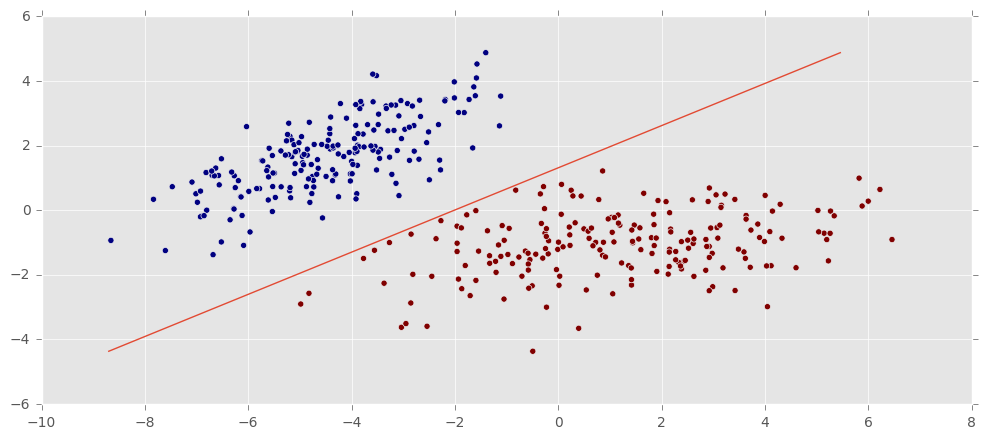

In [56]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([-5, -3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.zeros(200), np.ones(200)]


model = MySGDClassifier(max_epoch=10, alpha=0.5, C=0.01).fit(X, y)

print 'Weights:', model.beta

plt.scatter(X[:,0], X[:,1], c=y)
x_arr = np.array([X[:,0].min(), X[:,0].max()])
y_arr = np.array([X[:,1].min(), X[:,1].max()])
plt.plot(-(y_arr*model.beta[2] + model.beta[0]) / model.beta[1], y_arr) 

In [57]:
model = MySGDClassifier()
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, max_epoch=10, random_state=None)

In [ ]:
## Your Code Here

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Веса:
[ 4.56341879 -1.08668498  0.89013005]


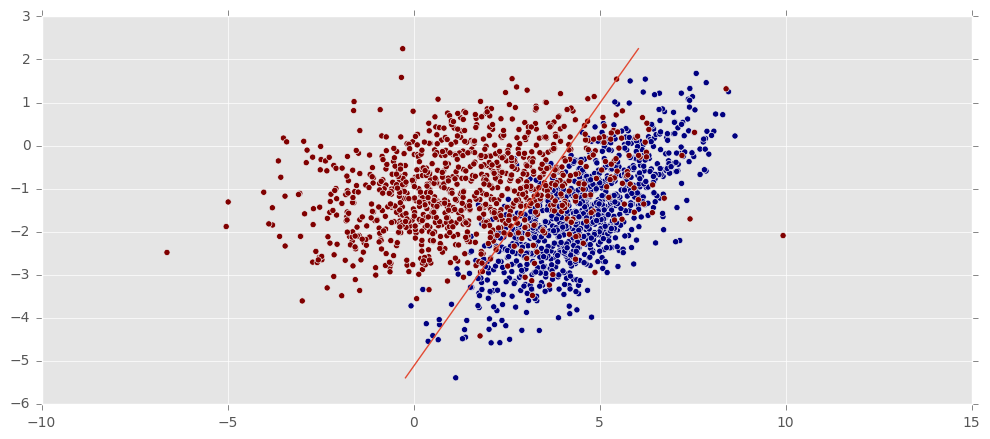

In [59]:
np.random.seed(0)

C_first  = np.array([[0., -0.8], [1.5, 0.8]])
C_second = np.array([[1., -0.7], [2., 0.7]])

gauss_first  = np.dot(np.random.randn(1000, 2) + np.array([5, 3]), C_first)
gauss_second = np.dot(np.random.randn(1000, 2) + np.array([1.5, 0]), C_second)

X = np.vstack([gauss_first, gauss_second])
y = np.r_[np.zeros(1000), np.ones(1000)]
model = MySGDClassifier(max_epoch=10, alpha=0.2, C=0.01).fit(X, y)

print 'Веса:'
print model.beta

plt.scatter(X[:,0], X[:,1], c=y)

x_arr = np.array([X[:,0].min(), X[:,0].max()])
y_arr = np.array([X[:,1].min(), X[:,1].max()])

plt.plot(-(y_arr*model.beta[2]+model.beta[0])/model.beta[1], y_arr) 

Покажем зависимость ошибки от количества эпох для различных значений alpha. Мера ошибки - доля неправильно классифицированных объектов. 

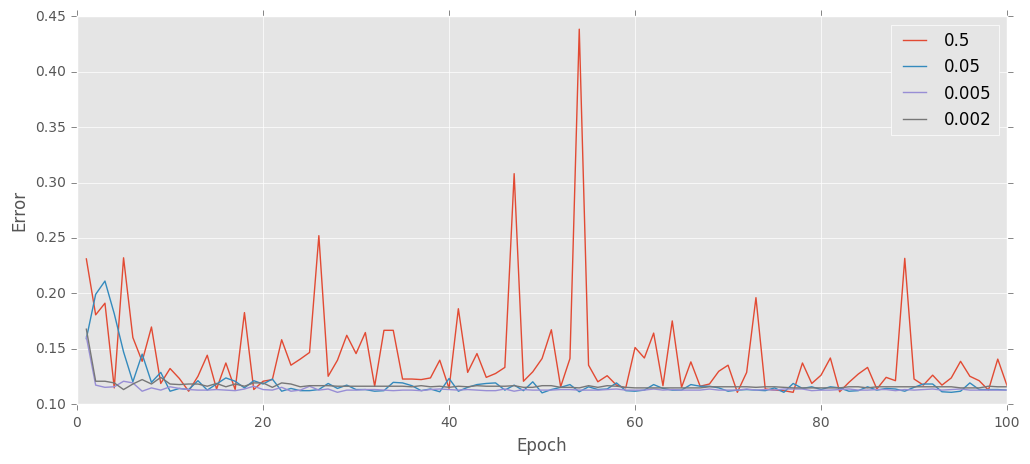

In [60]:
for alpha in (0.5, 0.05, 0.005, 0.002):
    model = MySGDClassifier(max_epoch=100, alpha=alpha, C=0.01).fit(X, y)
    plt.plot(xrange(1,101), model.errors, label=str(alpha))
plt.xlabel(u'Epoch')
plt.ylabel(u'Error')
plt.legend()

Наиболее оптимальные значения alpha в нашем случае 0.05 - 0.005. Для alpha = 0.5 скачки слишко большие и узкие, поэтому мы можем перепрыгнуть экстремум. 

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [64]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

IOError: File ./trainingData_tabular_chunk1.csv does not exist

In [65]:
df_data.shape

NameError: name 'df_data' is not defined

In [66]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

NameError: name 'df_data' is not defined

In [67]:
df_data.head().T

NameError: name 'df_data' is not defined

In [68]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

NameError: name 'df_data' is not defined

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [61]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [62]:
## Youd Code Here

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [63]:
## Youd Code Here